# Identifying Functional Motifs via Self-Attention

## 1. The Concept: Self-Attention Maps
Inside the Transformer, every "Head" looks at the sequence differently. Some heads look for local patterns (neighboring amino acids), while others look for distant structural contacts (amino acids that are far apart in the sequence but touch in 3D space).

## 2. Setup & Model Loading
We need to load the model with a specific flag: `output_attentions=True`.

In [1]:
import torch
from transformers import AutoTokenizer, EsmModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load model with attention output enabled
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmModel.from_pretrained(model_name, output_attentions=True)

# Let's pick a sequence Zinc finger
sequence = "RECVNCGATATPLWRRDRTGHYLCNACGLYHKMNGQN" 
inputs = tokenizer(sequence, return_tensors="pt")

Loading weights:   0%|          | 0/107 [00:00<?, ?it/s]

EsmModel LOAD REPORT from: facebook/esm2_t6_8M_UR50D
Key                         | Status     | 
----------------------------+------------+-
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
esm.embeddings.position_ids | UNEXPECTED | 
pooler.dense.bias           | MISSING    | 
pooler.dense.weight         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In PyTorch and the transformers library, the inputs object is a BatchEncoding—which you can think of as a "Super Dictionary."

When you run inputs = tokenizer(sequence, return_tensors="pt"), the tokenizer takes your string of amino acids (or DNA) and converts it into the specific numerical format the Transformer "brain" requires.

If you were to print inputs, you would see it contains two main keys:

1. input_ids (The Vocabulary Map)
This is a tensor of integers. Every amino acid has a specific "ID number" in the ESM-2 dictionary.
* Example: M might be 21, A might be 5.
* Special Tokens: You’ll notice the sequence starts and ends with specific IDs (like 0 or 2). These are <cls> (start) and <eos> (end) tokens that tell the model where the protein begins and ends.
* Shape: [1, sequence_length]. The 1 is the batch size.

2. attention_mask (The "Ignore This" Map)
This is a tensor of 1s and 0s.
* 1: Means "This is a real amino acid, pay attention to it."
* 0: Means "This is just empty padding (zeros) used to make sequences the same length; ignore it."
* In your for-loop, this will be all 1s, but it's required for the model to function.

In [2]:
inputs

{'input_ids': tensor([[ 0, 10,  9, 23,  7, 17, 23,  6,  5, 11,  5, 11, 14,  4, 22, 10, 10, 13,
         10, 11,  6, 21, 19,  4, 23, 17,  5, 23,  6,  4, 19, 21, 15, 20, 17,  6,
         16, 17,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [3]:
inputs['input_ids'].shape

torch.Size([1, 39])

## 3. Extracting the Attention
When you run the model now, it returns an extra object containing the attention weights for every layer and every head.

In [4]:
with torch.no_grad():
    outputs = model(**inputs)

# 'attentions' is a tuple of 6 tensors (one for each layer in the 8M model)
# Each tensor has shape: [Batch_size, Num_Heads, Seq_Len, Seq_Len]
attentions = outputs.attentions 

# Let's look at the very last layer (Layer 6)
last_layer_attention = attentions[-1].squeeze(0) # Remove batch dim -> [Num_Heads, Seq_Len, Seq_Len]

In [5]:
len(attentions) ## 6 layers

6

In [6]:
last_layer_attention.shape ## 4 heads, 30 * 30 attention map (including start and end tokens)

torch.Size([20, 39, 39])

## 4. Visualizing a Single Attention HeadEach head is a square matrix. 
If position $(i, j)$ is dark, it means amino acid $i$ is paying a lot of attention to amino acid $j$.

Key things to look for:
* Identify "Diagonal" Attention: You will likely see a strong diagonal line. This means the model is looking at the amino acids right next to each other (local grammar).
* Find "Contact" Attention: Look for bright spots off the diagonal. These are the most exciting! They represent the model identifying long-range interactions (folding).
* Compare Heads: Plot Head 1 vs. Head 5. You’ll notice they focus on different parts of the protein.

|Pattern|Technical Name|Biological Interpretation|
|-------|--------------|-------------------------|
|Sharp Diagonal|Local Attention|Neighboring amino acid interactions (Primary sequence).|
|Broad Diagonal|Windowed Attention|Identifying Secondary Structures (Alpha Helices/Beta Sheets).|
|Isolated Spots|Long-Range Contact|3D Folding and distant residue interactions.|
|Uniform/Empty|Null/Global Attention|"""Idle"" heads or global sequence averaging."|

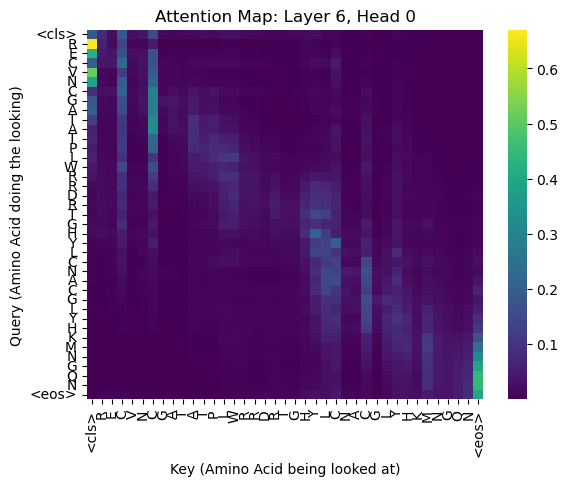

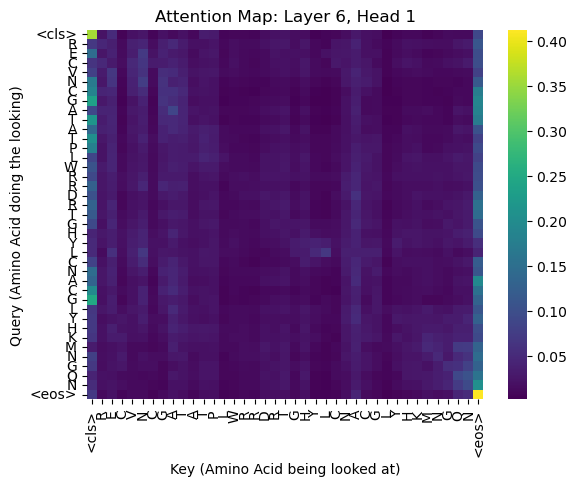

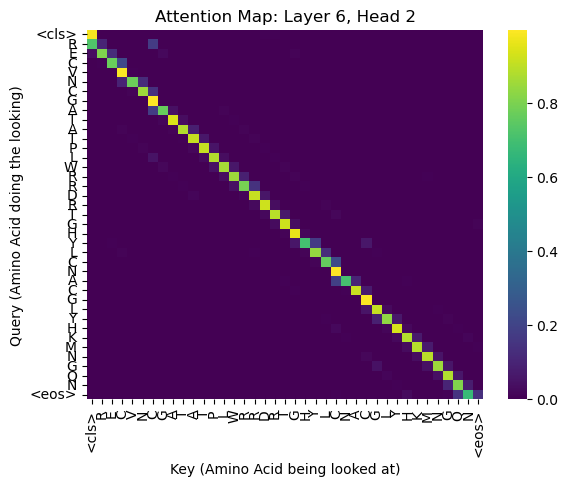

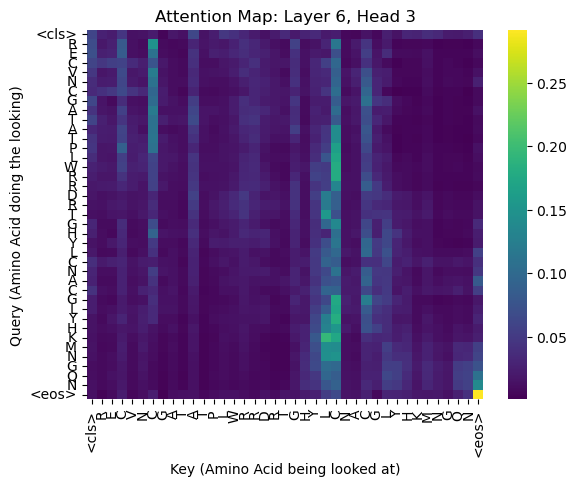

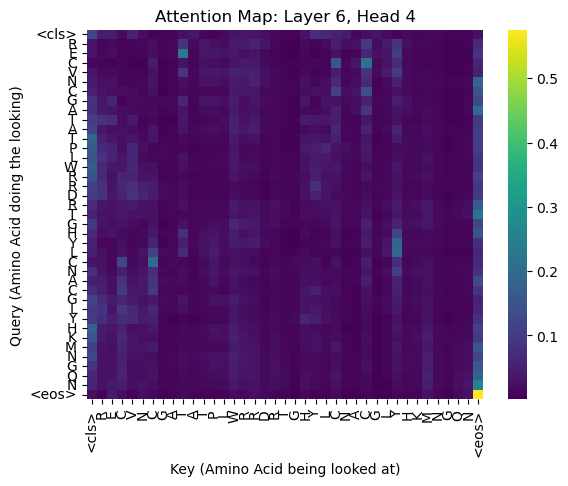

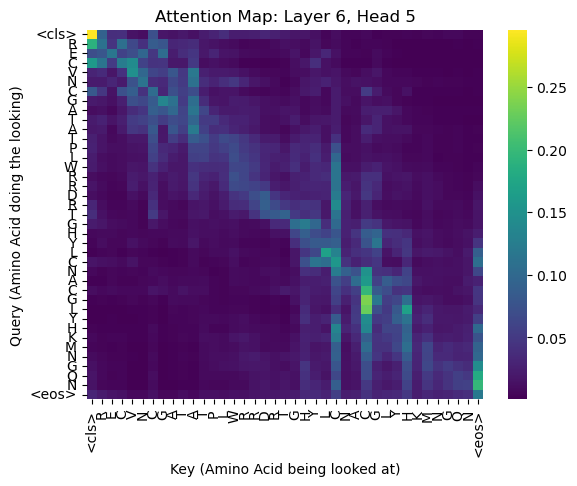

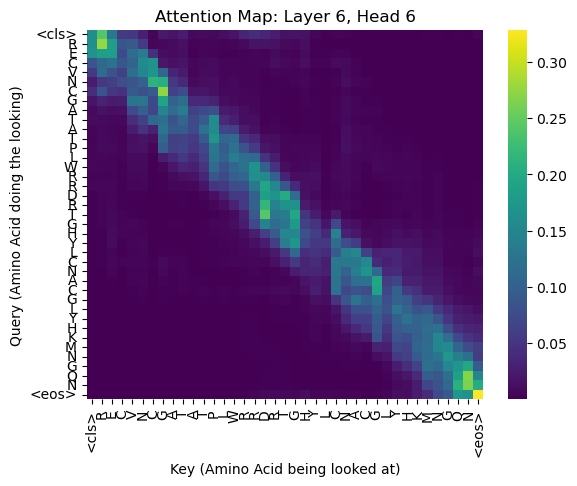

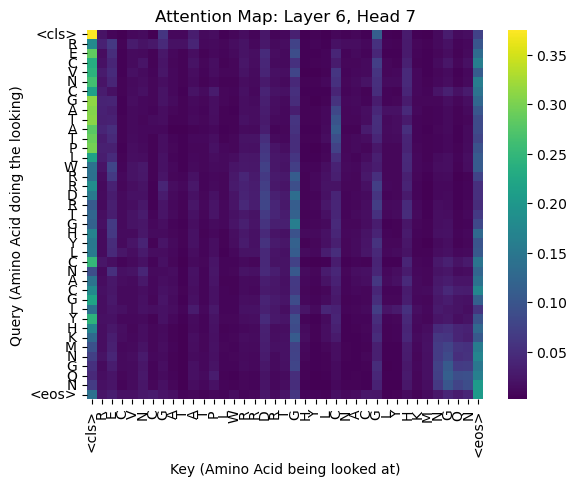

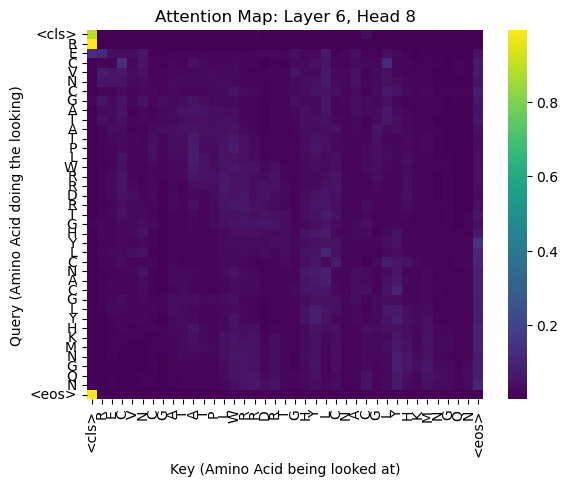

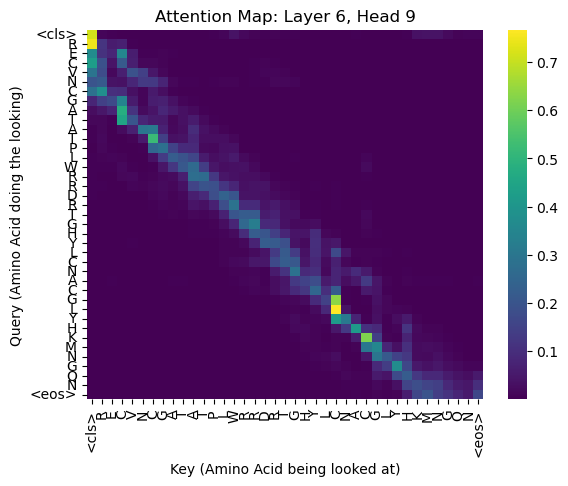

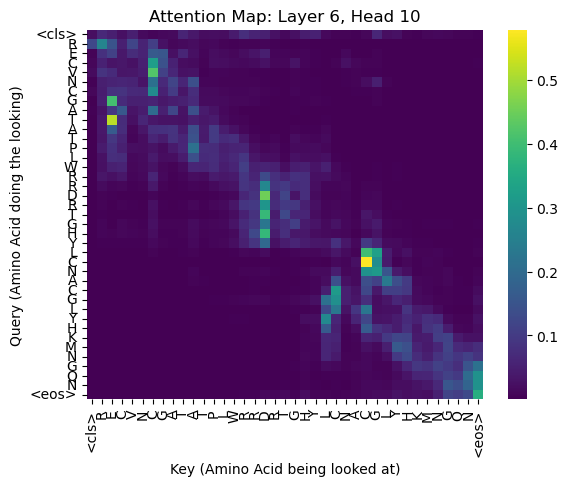

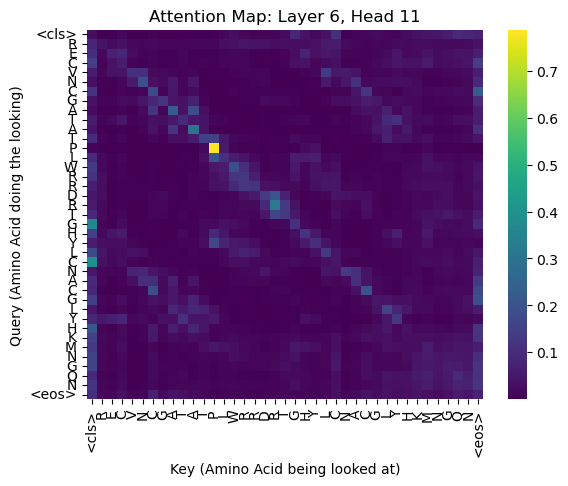

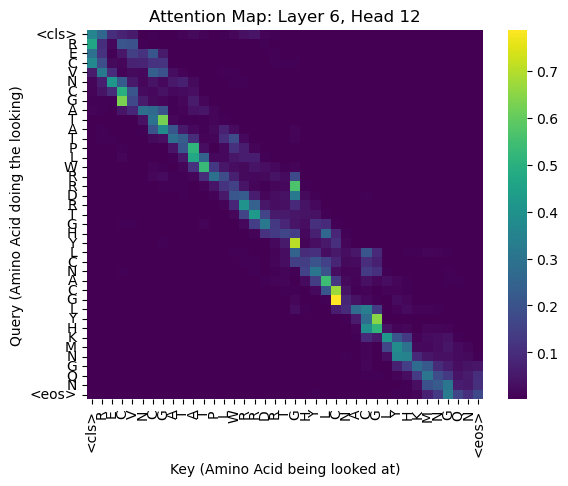

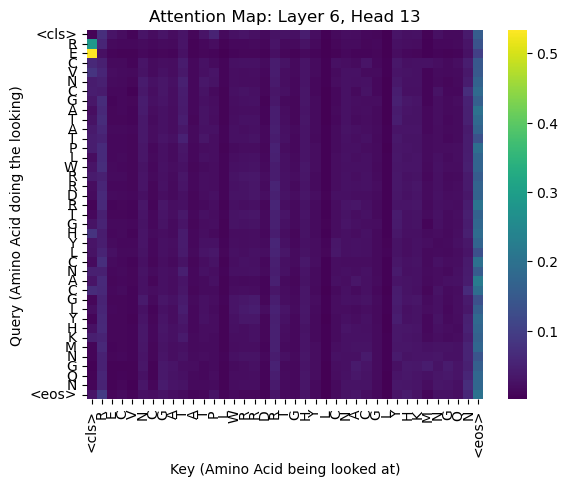

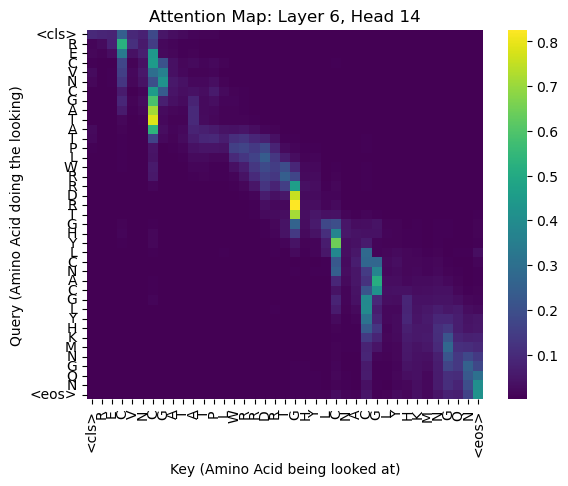

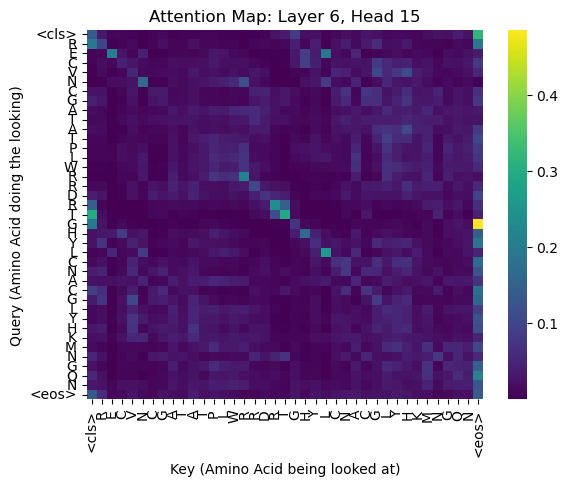

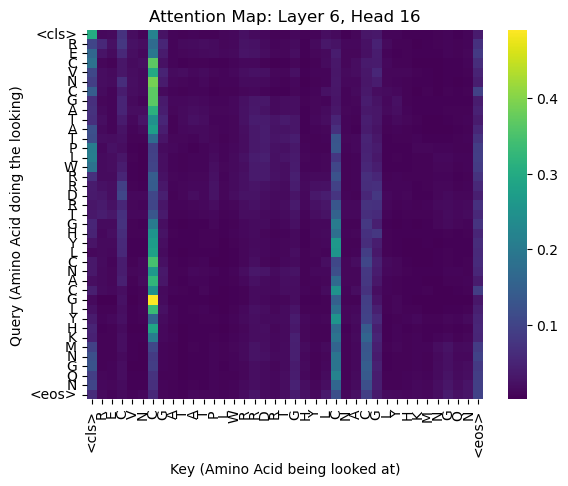

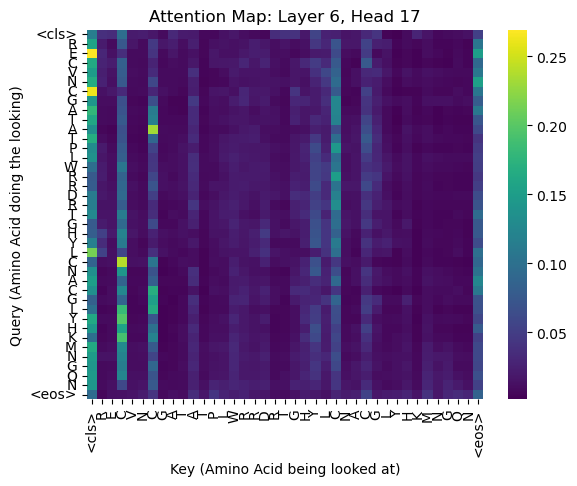

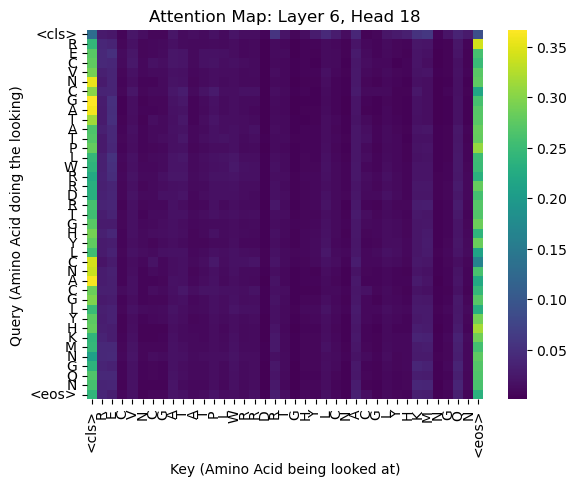

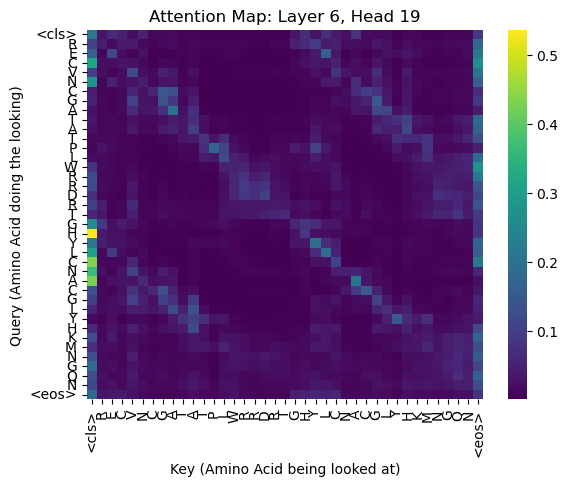

In [7]:
def plot_attention_head(attention_matrix, tokens, head_index):
    plt.figure()
    sns.heatmap(attention_matrix[head_index].numpy(), 
                xticklabels=tokens, 
                yticklabels=tokens, 
                cmap="viridis")
    plt.title(f"Attention Map: Layer 6, Head {head_index}")
    plt.xlabel("Key (Amino Acid being looked at)")
    plt.ylabel("Query (Amino Acid doing the looking)")
    plt.show()

# Convert tokens for labels
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
for head_index in range(last_layer_attention.shape[0]):
    plot_attention_head(last_layer_attention, tokens, head_index=head_index)

## 5. Validate high-attention motif: The GATA-1 Case Study

To validate the model's interpretability, I analyzed a C4-type Zinc Finger. By calculating a Residue Importance Score (the sum of attention received by each residue in the final layer), I found that the model assigned the highest attention to the four conserved Cysteine residues (C3, C6, C24, C27).

This demonstrates that the Transformer's self-attention mechanism naturally prioritizes chemically active, evolutionarily conserved sites that are critical for protein folding and metal-ion coordination.
### The Target
The protein we used for embedding is a classic C4-type Zinc Finger. It has the known Motif: This protein uses 4 specific Cysteines (C) to "grab" a Zinc ion. If the model is smart, it should pay massive attention to these 4 Cysteines because they are the "functional anchors" of the protein.

### The Code: Extracting "High-Attention Sites" (HAS)
We will sum the attention across the final layer to see which residues the model thinks are the "most important" for the sequence's identity.

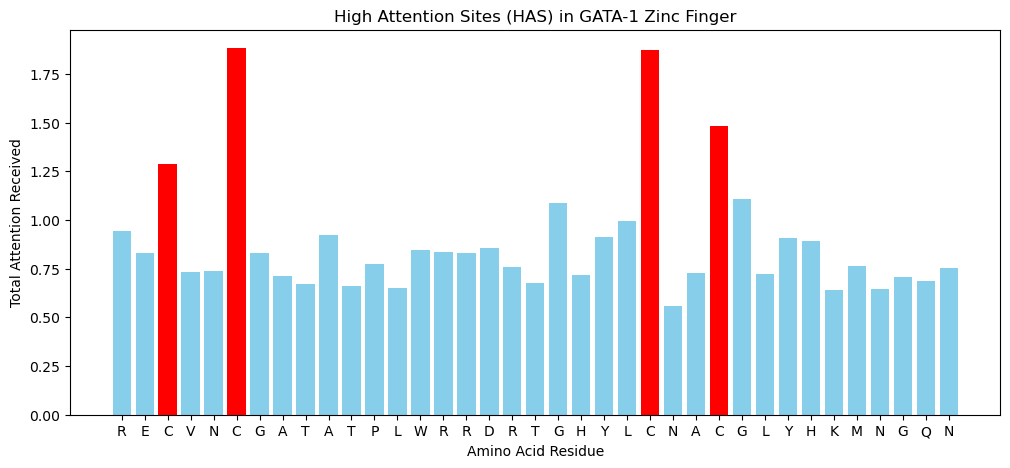

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt



# 3. Calculate "Importance Score" 
# We average across all heads, then sum how much everyone looks AT each residue
avg_attn = last_layer_attention.mean(dim=0) # [Seq, Seq]
importance_scores = avg_attn.sum(dim=0).cpu().numpy() # Sum of attention received by each AA

# 4. Cleanup tokens (remove <cls> and <eos>)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
# Remove the first and last tokens for the plot
plot_tokens = tokens[1:-1]
plot_scores = importance_scores[1:-1]

# 5. Visualize the "High Attention Sites"
plt.figure(figsize=(12, 5))
colors = ['red' if 'C' in t else 'skyblue' for t in plot_tokens] # Highlight Cysteines
plt.bar(range(len(plot_tokens)), plot_scores, color=colors)
plt.xticks(range(len(plot_tokens)), plot_tokens)
plt.title("High Attention Sites (HAS) in GATA-1 Zinc Finger")
plt.ylabel("Total Attention Received")
plt.xlabel("Amino Acid Residue")
plt.show()